#Complete Machine Learning Pipeline to Predict Car Prices

The goal of this project will be to predict car prices given a few features:
year, price, road tax, transmission, mpg, mileage and engine size. The amount of features aren't comprehensive however we should be able to extract enough information from the dataset to make a prediction. This is very clearly a regression task and as such, we will play around with some different regressors to see what kind of conclusion we can reach.

# Initialization and Basic Overview

Let's start by loading the data & general libraries and getting some basic insights as to how the data is structured:

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import shuffle
car_data = pd.read_csv('car_data.csv')
car_data = shuffle(car_data)
car_data.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,tax(£)
62790,GLA Class,2019,23599,Semi-Auto,15588,Diesel,145.0,67.3,2.1,NaN
49295,Tucson,2016,12298,Manual,38564,Diesel,NaN,61.7,1.7,30.0
4048,Q7,2019,66990,Automatic,6000,Diesel,145.0,33.2,3.0,NaN
40807,Fiesta,2018,12795,Manual,10419,Petrol,145.0,65.7,1.0,NaN
76790,Aygo,2017,7998,Manual,6730,Petrol,145.0,68.9,1.0,NaN


Note: I shuffled the data because the data was originally split into multiple csv files that were grouped by brand and I combined them manually. This led to some artifical segmentation that I want to get rid of.

In [2]:
car_data.describe()

,year,price,mileage,tax,mpg,engineSize,tax(£)
count,79751.000000,79751.000000,79751.000000,65538.000000,70398.000000,79751.000000,4860.000000
mean,2017.091886,18008.115622,23122.361914,120.223229,56.174424,1.715005,121.147119
std,2.147783,10368.458018,21357.930109,64.980767,17.421733,0.600046,58.003289
min,1970.000000,495.000000,1.000000,0.000000,1.100000,0.000000,0.000000
25%,2016.000000,10948.500000,7460.000000,125.000000,47.900000,1.200000,125.000000
50%,2017.000000,15940.000000,17133.000000,145.000000,56.500000,1.600000,145.000000
75%,2019.000000,22299.000000,32313.000000,145.000000,64.200000,2.000000,145.000000
max,2060.000000,159999.000000,323000.000000,580.000000,470.800000,6.600000,555.000000


We found some obvious outliers in the year and mpg columns. We will deal with these when we get to cleaning, for now let's continue looking at the dataset.

In [3]:
car_data['year'].value_counts()

,count
year,
2019,22099
2017,17614
2016,11799
2018,11497
2015,6136
2014,3256
2020,3181
2013,2181
2012,525


In [4]:
dummy = car_data[car_data['mpg']>70]
dummy['mpg'].value_counts()

,count
mpg,
74.3,1875
72.4,1059
70.6,903
78.5,772
76.3,270
80.7,229
134.5,184
78.0,169
76.4,166


In [5]:
car_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79751 entries, 62790 to 74641
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         79751 non-null  object 
 1   year          79751 non-null  int64  
 2   price         79751 non-null  int64  
 3   transmission  79751 non-null  object 
 4   mileage       79751 non-null  int64  
 5   fuelType      79751 non-null  object 
 6   tax           65538 non-null  float64
 7   mpg           70398 non-null  float64
 8   engineSize    79751 non-null  float64
 9   tax(£)        4860 non-null   float64
dtypes: float64(4), int64(3), object(3)
memory usage: 6.7+ MB


Column 9 seems to be mostly null, we can get rid of it and we can also fill in the other columns with the median or mean values.

Let's plot the data to see how it is distributed.

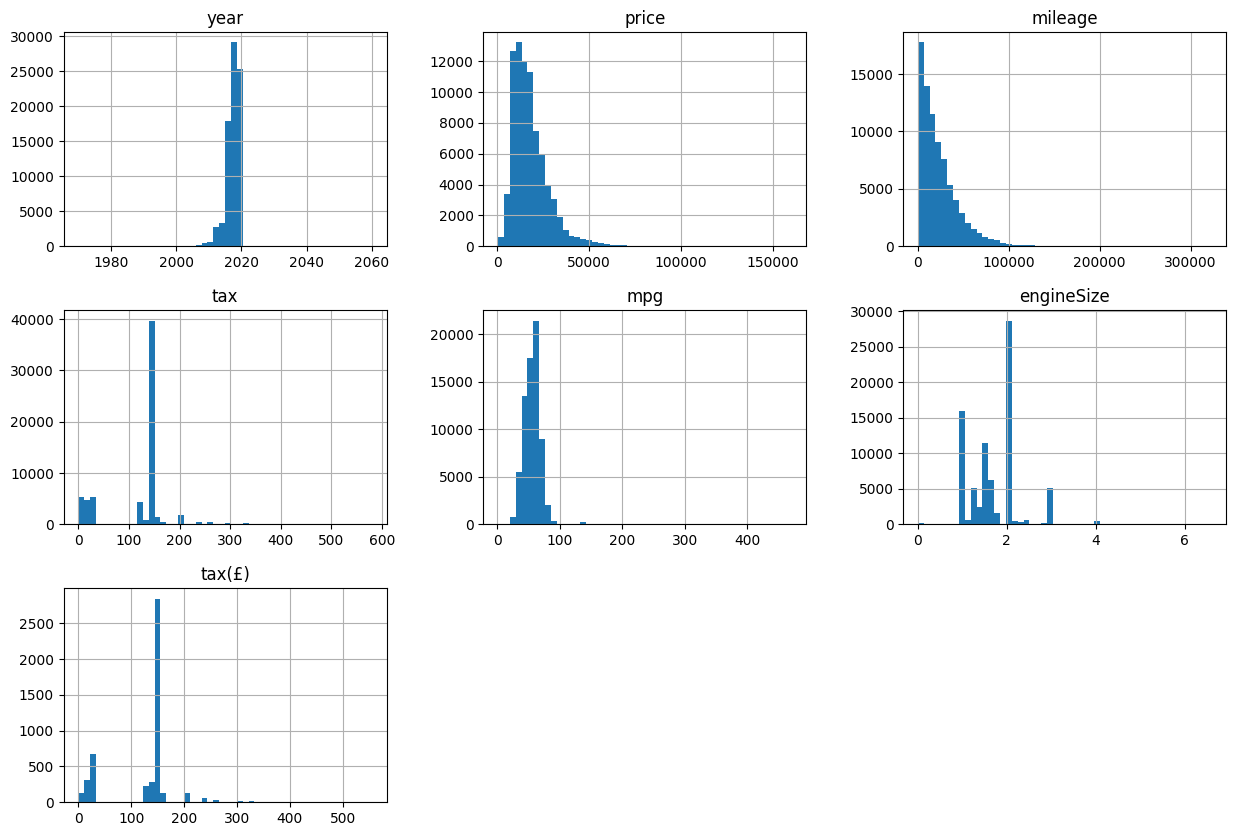

In [6]:
car_data.hist(bins=50, figsize=(15,10))
plt.show()

The data seems to be heavily skewed and have different scales, we will transform and normalize them before we train models.

# Train Test Split


Let's split the data early so that we will only work with the training set from here on out:

In [7]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(car_data, test_size=0.2, random_state=42)

And let's copy the train set just in case we would like to revert to it at any point:

In [8]:
car_data = train_set.copy()

# Data Visualization

Let's look at the correlations to see which of the features are most useful:

In [9]:
correlations = car_data.corr(numeric_only=True)
correlations['price'].sort_values(ascending=False)

,price
price,1.000000
engineSize,0.632913
year,0.499400
tax(£),0.331782
tax,0.324401
mpg,-0.322002
mileage,-0.434696


All the numeric features seem to have a decently strong correlation with price however, we will probably remove the tax(£) column as only about 5% of the entries have a value for it

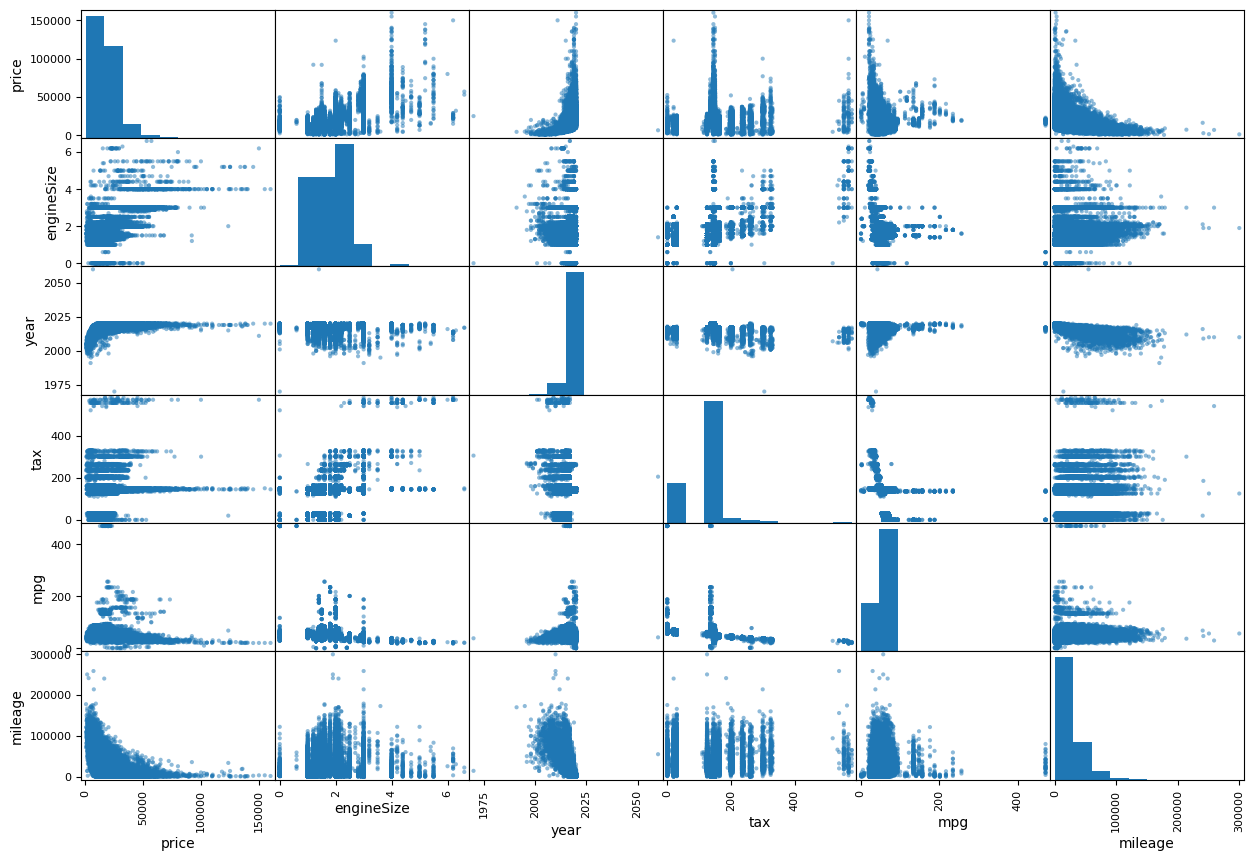

In [10]:
features = ['price','engineSize','year','tax','mpg','mileage']

from pandas.plotting import scatter_matrix
scatter_matrix(car_data[features], figsize=(15,10))
plt.show()

# Cleaning the Data

We have gained some insights on how to move forward and now we can perform some cleanup of the data. The dataset is already relatively clean however we can remove some unnecessary columns and fill in others as noted in the previous cells. We also have yet to transform the non-numeric columns.

In [11]:
car_data.drop('tax(£)', inplace=True, axis=1)
car_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63800 entries, 50252 to 10949
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         63800 non-null  object 
 1   year          63800 non-null  int64  
 2   price         63800 non-null  int64  
 3   transmission  63800 non-null  object 
 4   mileage       63800 non-null  int64  
 5   fuelType      63800 non-null  object 
 6   tax           52451 non-null  float64
 7   mpg           56318 non-null  float64
 8   engineSize    63800 non-null  float64
dtypes: float64(3), int64(3), object(3)
memory usage: 4.9+ MB


Lets split the price column so that we are only working with the attributes

In [12]:
car_data = train_set.drop('price', axis=1)
car_data_labels = train_set['price'].copy()

Let's make a pipeline to fill in the data and transform it instead of doing every column manually.

In [13]:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_selector

def log_transform(x):
    return np.log(x + 1e-10) #We will use this log method as the 0 values in the tax column return undefined values with np.log

log_transformer = make_pipeline(
    SimpleImputer(strategy='median'),
    FunctionTransformer(log_transform, feature_names_out='one-to-one'),
    StandardScaler()
)
category_transformer = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)
num_transformer = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

preprocessing = ColumnTransformer([
    ('log', log_transformer,['year','mpg', 'mileage', 'tax']),
    ('cat', category_transformer, make_column_selector(dtype_include=object)),
    ('num', num_transformer, make_column_selector(dtype_exclude=object))],
    remainder=num_transformer
)


# Model Selection and Training

We have our pipeline, now let's try it out on some different models:

In [14]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(car_data, car_data_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('log',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function log_...
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7b51a61c1c90>),
                                                 ('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7b51a61c36d0>)])),
                ('linearregression', LinearRegression())])

Lets compare our predictions to the actual values:

In [15]:
car_data_predictions = lin_reg.predict(car_data)
car_data_predictions[:5].round(1)

array([ 9130.9, 34088.3, 20867.7, 27152.6,  9338.1])

In [16]:
car_data_labels.iloc[:5].values

array([ 9250, 34412, 21995, 31999,  7995])

In [17]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

lin_rmse = root_mean_squared_error(car_data_labels, car_data_predictions)
lin_mae = mean_absolute_error(car_data_labels, car_data_predictions)
lin_r2 = r2_score(car_data_labels, car_data_predictions)

print(f'Root Mean Squared Error: {lin_rmse}')
print(f'Mean Absolute Error: {lin_mae}')
print(f'R2 Score: {lin_r2}')

Root Mean Squared Error: 3746.2812920443052
Mean Absolute Error: 2284.860241994065
R2 Score: 0.869534159213628


Our linear regressor doesn't seem to be horrible, but let's try another model to see if we can do better.

In [18]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor())
tree_reg.fit(car_data, car_data_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('log',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function log_...
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7b51a61c1c90>),
                                                 ('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7b51a61c36d0>)])),
                ('decisiontreeregressor', DecisionTreeRegressor())])

In [19]:
car_data_predictions = tree_reg.predict(car_data)
car_data_predictions[:5].round(1)

array([ 9250. , 34412. , 21995. , 33229.7,  7995. ])

In [20]:
tree_rmse = root_mean_squared_error(car_data_labels, car_data_predictions)
tree_mae = mean_absolute_error(car_data_labels, car_data_predictions)
tree_r2 = r2_score(car_data_labels, car_data_predictions)

print(f'Root Mean Squared Error: {tree_rmse}')
print(f'Mean Absolute Error: {tree_mae}')
print(f'R2 Score: {tree_r2}')

Root Mean Squared Error: 228.683519146927
Mean Absolute Error: 24.966431349523187
R2 Score: 0.9995138550441294


Although our error coefficients vary slightly, judging by the first few predictions (which seem to be exactly the same as the target values) our model is overfitting.

Finally, let's try a random forest regressor to see what we achieve before moving onto cross validation:

In [52]:
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

xgb_reg = xgb.XGBRegressor(device='cuda', n_estimators=100, learning_rate=0.1,
                           max_depth=6
)
#forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))
forest_reg = make_pipeline(preprocessing, xgb_reg)
forest_reg.fit(car_data, car_data_labels)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('log',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function log_...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=6, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=100, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [53]:
car_data_predictions = forest_reg.predict(car_data)
car_data_predictions[:5].round(1)

array([ 9247.9, 34521.6, 18977. , 30429.9,  8832.4], dtype=float32)

In [28]:
car_data_labels.iloc[:5].values

array([ 9250, 34412, 21995, 31999,  7995])

In [29]:
forest_rmse = root_mean_squared_error(car_data_labels, car_data_predictions)
forest_mae = mean_absolute_error(car_data_labels, car_data_predictions)
forest_r2 = r2_score(car_data_labels, car_data_predictions)

print(f'Root Mean Squared Error: {forest_rmse}')
print(f'Mean Absolute Error: {forest_mae}')
print(f'R2 Score: {forest_r2}')

Root Mean Squared Error: 2408.5534535344805
Mean Absolute Error: 1632.9247660535855
R2 Score: 0.9460726976394653


Our model is less overfit, however it is still significant considering a 94% accuracy and seeing some of the predicted values are almost exactly the same as the target values.

## Cross Validation

Since our decision tree is most likely overfitting, let us use cross validation to see how it performs acrosss multiple iterations of training:

In [30]:
from sklearn.model_selection import cross_val_score

tree_scores = -cross_val_score(tree_reg, car_data, car_data_labels,
                               scoring='neg_root_mean_squared_error', cv=10)

pd.Series(tree_scores).describe()

,0
count,10.000000
mean,2737.779561
std,158.842582
min,2490.894156
25%,2647.017877
50%,2719.231160
75%,2811.561493
max,3055.562737


Let's run it again but with out linear model to see how much of an improvement (if any) this is. Our error coefficients from the previous cells were only based on one training instance. Let us use 10 folds for cross validation just like with the tree validation:

In [31]:
linreg_scores = -cross_val_score(lin_reg, car_data, car_data_labels,
                                 scoring='neg_root_mean_squared_error', cv=10)
pd.Series(linreg_scores).describe()

,0
count,10.000000
mean,3807.746626
std,292.960909
min,3530.186164
25%,3647.122423
50%,3715.451681
75%,3832.408052
max,4547.144661


It seems like using a decision tree is ~30% better than a linear model even if it is overfitting

Let us now check the cross validation score on our forest regressor:

In [32]:
forest_scores = -cross_val_score(forest_reg, car_data, car_data_labels,
                                 scoring='neg_root_mean_squared_error', cv=10)
pd.Series(forest_scores).describe()

,0
count,10.000000
mean,2588.601890
std,169.915324
min,2439.296981
25%,2468.152959
50%,2568.828381
75%,2589.089813
max,3005.439563


We'll try to improve upon the random forest as it has slightly better performance than the decision tree alone.

# Parameter Tuning

We don't have a lot of paramaters in our preprocessing pipeline however, we can still tune the parameters in the XGBoost random forest regressor:

In [60]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

final_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('random_forest', xgb_reg)
])

tuning_params = {
    'random_forest__n_estimators':randint(90,200),
    'random_forest__learning_rate':[0.001, 0.01, 0.05, 0.1, 0.2, 0.3],
    'random_forest__max_depth':randint(6, 16),
}

random_search = RandomizedSearchCV(final_pipeline,
                                   param_distributions=tuning_params,
                                   n_iter=10, cv=3,
                                   scoring='neg_root_mean_squared_error',
                                   random_state=42)

random_search.fit(car_data, car_data_labels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('log',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_out='...
                                                           random_state=None, ...))]),
                   param_distributions={'random_forest__learning_rate': [0.001,
                                                                         0.01,
                                                                         0.05,
                                                                         0.1,
                                                                         0.2,
                                                                         0.3],
                                        'random_forest__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b51a8833f10>,
                                        'random_forest__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b51a9286980>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [65]:
final_model = random_search.best_estimator_
feature_weights = final_model['random_forest'].feature_importances_
feature_weights.round(5)

array([1.4550e-02, 2.3400e-03, 8.9000e-04, 6.8000e-04, 5.7800e-03,
       7.3300e-03, 3.6100e-03, 5.6300e-03, 2.7500e-03, 1.7300e-03,
       4.8700e-03, 7.5900e-03, 1.7760e-02, 5.3100e-03, 1.0000e-05,
       3.2100e-03, 1.1200e-03, 1.7000e-03, 2.4800e-03, 1.8100e-03,
       1.7500e-03, 1.0000e-05, 0.0000e+00, 4.2700e-03, 7.7000e-04,
       1.6120e-02, 4.3200e-03, 2.8900e-03, 9.2400e-03, 5.4400e-03,
       2.8900e-03, 2.3300e-03, 8.5000e-04, 0.0000e+00, 2.0000e-05,
       2.6600e-03, 6.4000e-04, 3.8500e-03, 1.2200e-03, 5.3000e-03,
       3.2600e-03, 1.1000e-03, 0.0000e+00, 1.0190e-02, 6.2500e-03,
       8.8500e-03, 1.1000e-04, 1.5420e-02, 5.8000e-04, 1.3400e-03,
       1.0400e-03, 1.9880e-02, 2.2820e-02, 2.5000e-03, 1.8100e-03,
       7.2000e-04, 3.0000e-05, 1.5900e-03, 2.4000e-04, 1.7600e-03,
       1.0520e-02, 3.4000e-03, 3.0000e-03, 8.4000e-04, 1.0910e-02,
       7.0000e-05, 5.6300e-03, 3.2000e-04, 9.0000e-04, 1.0100e-03,
       3.4900e-03, 1.8300e-03, 2.5500e-03, 2.6400e-03, 4.2000e

# Model Evaluation
It is finally time to evaluate our model on the test set:

In [66]:
x_test = test_set.drop('price', axis=1)
y_test = test_set['price'].copy()

y_hat = final_model.predict(x_test)

prediction_rmse = root_mean_squared_error(y_test, y_hat)
prediction_mae = mean_absolute_error(y_test, y_hat)
prediction_r2 = r2_score(y_test, y_hat)

print(f'Root Mean Squared Error: {prediction_rmse}')
print(f'Mean Absolute Error: {prediction_mae}')
print(f'R2 Score: {prediction_r2}')

Root Mean Squared Error: 1992.065347361258
Mean Absolute Error: 1186.102598448471
R2 Score: 0.9629901647567749


Works Great! It turns out our random forest in our first training iteration wasn't overfitting, it was just good right off the bat. Hyperparameter tuning seems to have improved the model by a decent amount. The RMSE improved by ~20% and the MAE improved by ~30%. Next, let's compute a confidence interval for our model predictions:

In [68]:
from scipy import stats

confidence = 0.95
squared_errors = (y_hat - y_test)**2
np.sqrt(stats.t.interval(confidence, len(squared_errors)-1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([1862.87310045, 2113.37467287])

Doesn't look too bad.

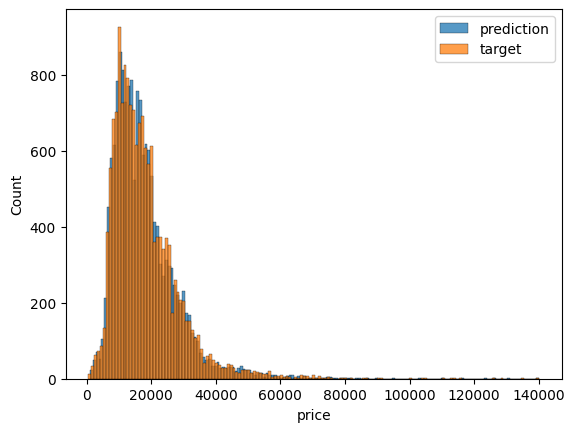

In [69]:
import seaborn as sns

sns.histplot(y_hat, label='prediction')
sns.histplot(y_test, label='target')
plt.legend()